# Load Libraries

In [3]:
# dl packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
    
# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# Load data

In [4]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [5]:
train_data

Comment  Emotion  length
0                                i didnt feel humiliated  sadness      23
1      i can go from feeling so hopeless to so damned...  sadness     108
2       im grabbing a minute to post i feel greedy wrong    anger      48
3      i am ever feeling nostalgic about the fireplac...     love      92
4                                   i am feeling grouchy    anger      20
...                                                  ...      ...     ...
15995  i just had a very brief time in the beanbag an...  sadness     101
15996  i am now turning and i feel pathetic that i am...  sadness     102
15997                     i feel strong and good overall      joy      30
15998  i feel like this was such a rude comment and i...    anger      59
15999  i know a lot but i feel so stupid because i ca...  sadness      62

[16000 rows x 3 columns]

In [6]:
train_data.shape

(16000, 3)

In [7]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [8]:
train_data.duplicated().sum()

1

In [9]:
train_data = train_data.drop_duplicates()

In [10]:
train_data.duplicated().sum()

0

# EDA

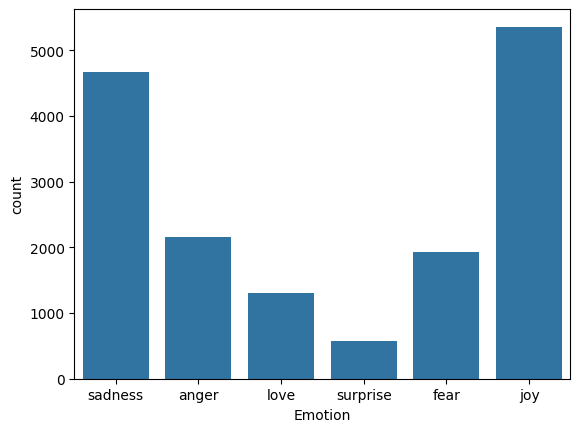

In [11]:
sns.countplot(x = train_data['Emotion'])
plt.show()

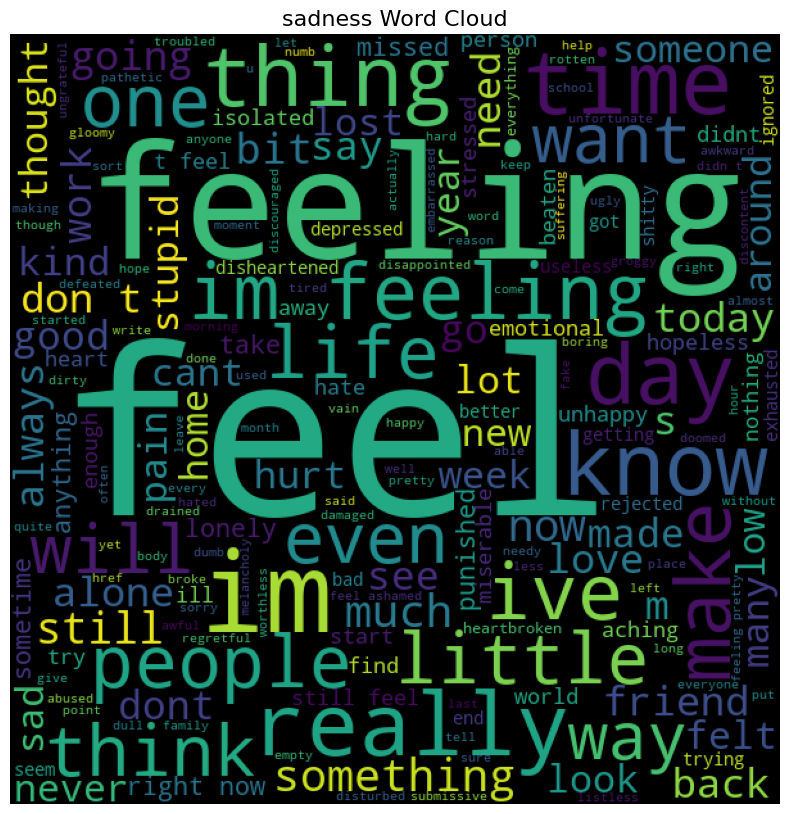

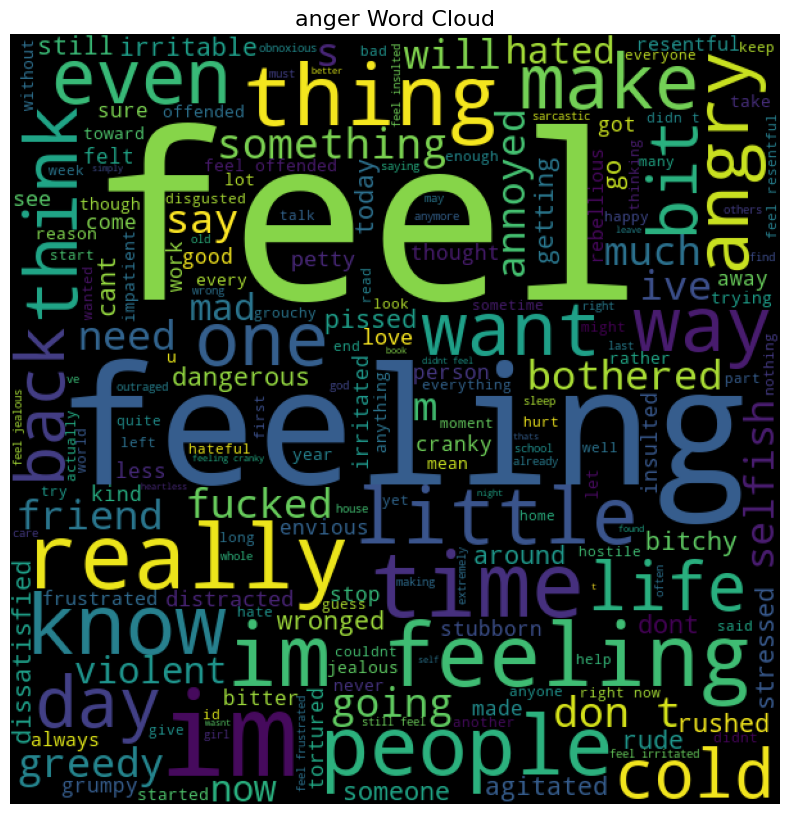

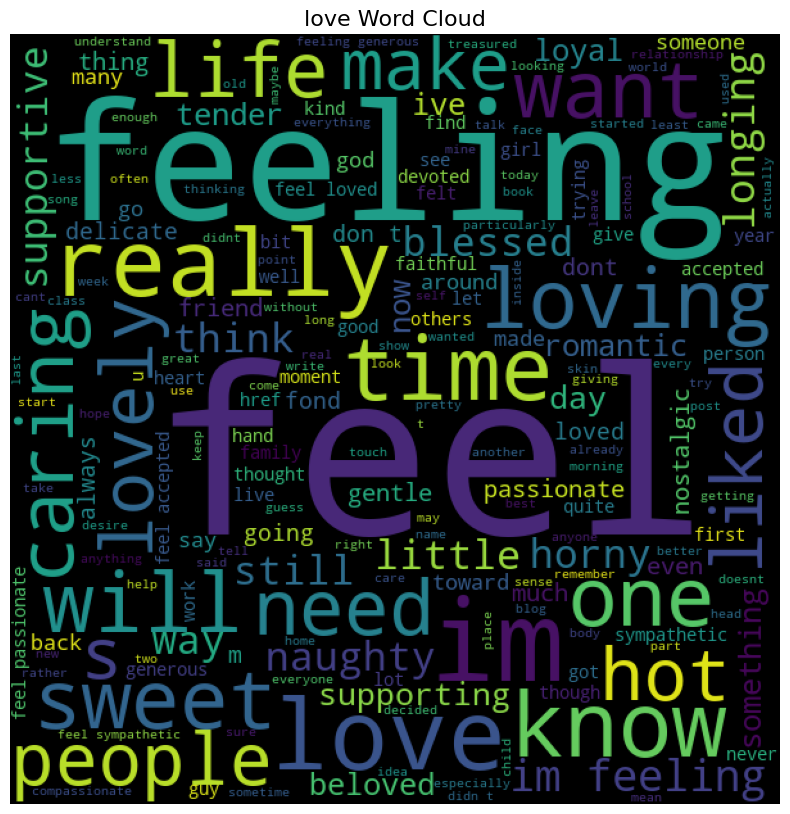

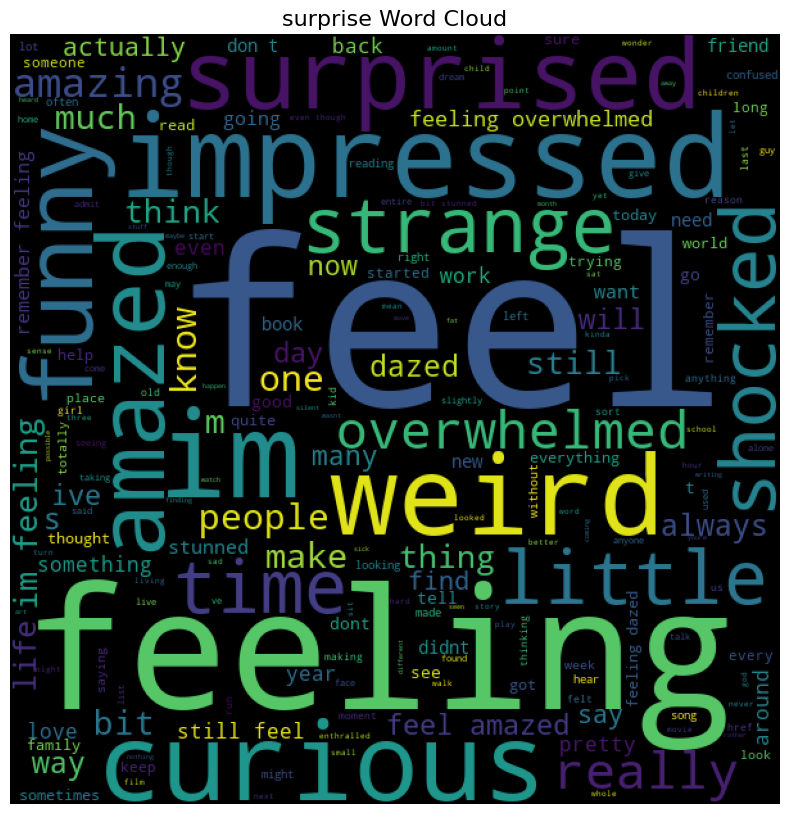

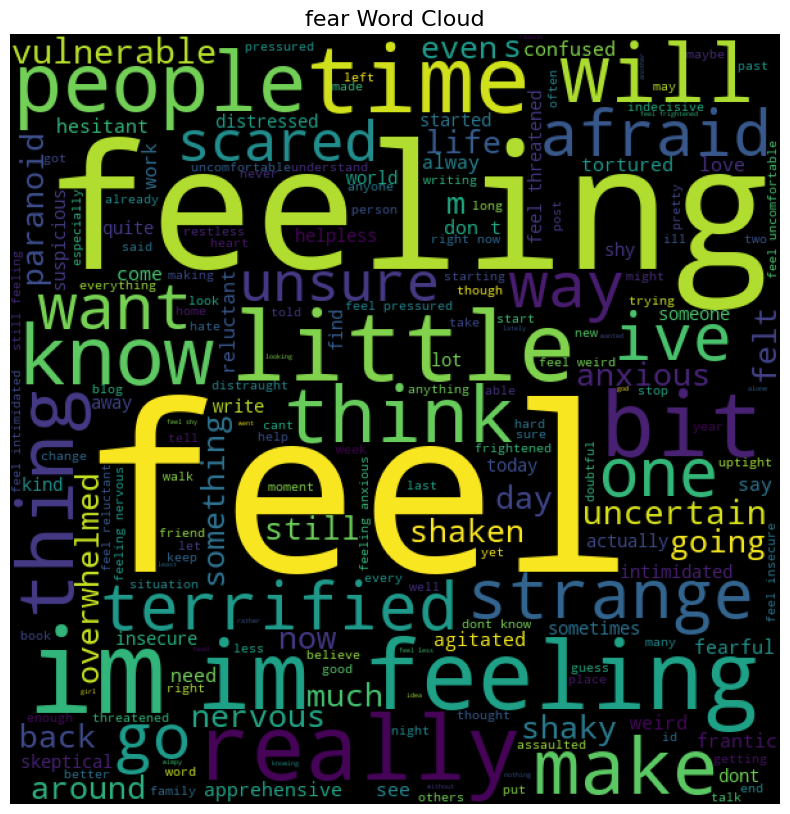

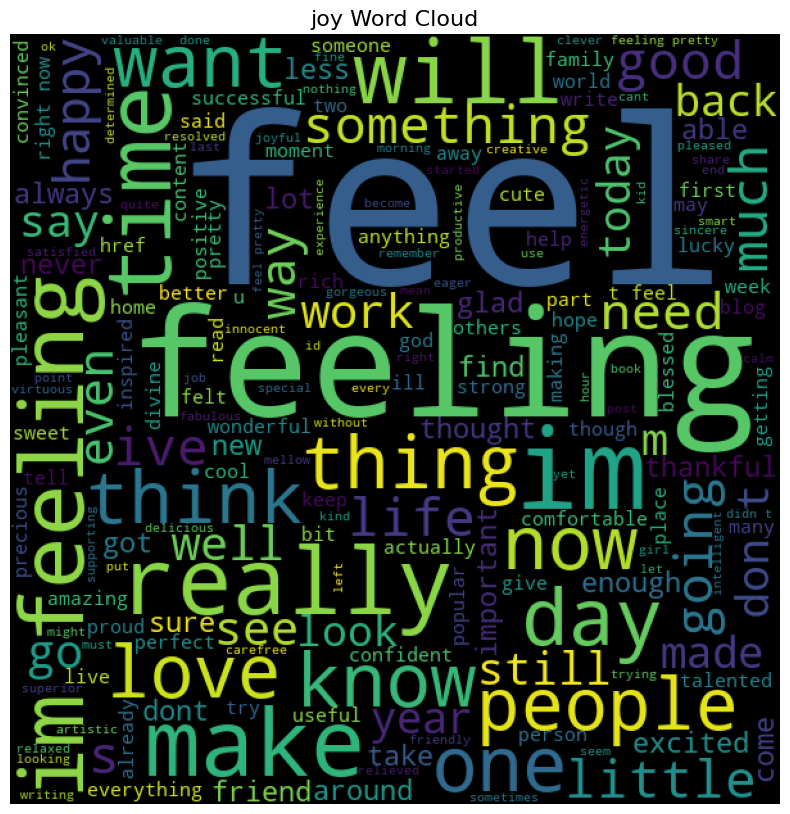

In [12]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Data Preprocessing
# Encode emotions

In [13]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

C:\Users\Yash lichade\AppData\Local\Temp\ipykernel_9580\3690270916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])


In [14]:
from sklearn.preprocessing import LabelEncoder

# Assuming train_data['Emotion'] contains the emotion classes
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

# Create a dictionary to map encoded labels to class names
label_map = {label: emotion for label, emotion in zip(lb.transform(lb.classes_), lb.classes_)}

# Print the label mapping
for label, emotion in label_map.items():
    print(f"Label: {label} -> Emotion: {emotion}")

Label: 0 -> Emotion: 0
Label: 1 -> Emotion: 1
Label: 2 -> Emotion: 2
Label: 3 -> Emotion: 3
Label: 4 -> Emotion: 4
Label: 5 -> Emotion: 5


C:\Users\Yash lichade\AppData\Local\Temp\ipykernel_9580\3517148550.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])


In [15]:
train_data

Comment  Emotion  length
0                                i didnt feel humiliated        4      23
1      i can go from feeling so hopeless to so damned...        4     108
2       im grabbing a minute to post i feel greedy wrong        0      48
3      i am ever feeling nostalgic about the fireplac...        3      92
4                                   i am feeling grouchy        0      20
...                                                  ...      ...     ...
15995  i just had a very brief time in the beanbag an...        4     101
15996  i am now turning and i feel pathetic that i am...        4     102
15997                     i feel strong and good overall        2      30
15998  i feel like this was such a rude comment and i...        0      59
15999  i know a lot but i feel so stupid because i ca...        4      62

[15999 rows x 3 columns]

In [16]:
print("Classes:", lb.classes_)
print("Encoded Labels:", lb.transform(lb.classes_))

Classes: [0 1 2 3 4 5]
Encoded Labels: [0 1 2 3 4 5]


In [17]:
df = train_data.copy() # copy df from train_data because we will use this for deep learing next

In [18]:
df

Comment  Emotion  length
0                                i didnt feel humiliated        4      23
1      i can go from feeling so hopeless to so damned...        4     108
2       im grabbing a minute to post i feel greedy wrong        0      48
3      i am ever feeling nostalgic about the fireplac...        3      92
4                                   i am feeling grouchy        0      20
...                                                  ...      ...     ...
15995  i just had a very brief time in the beanbag an...        4     101
15996  i am now turning and i feel pathetic that i am...        4     102
15997                     i feel strong and good overall        2      30
15998  i feel like this was such a rude comment and i...        0      59
15999  i know a lot but i feel so stupid because i ca...        4      62

[15999 rows x 3 columns]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [20]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to C:\Users\Yash
[nltk_data]     lichade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [22]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Applying Machine Learning

In [44]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.6590625
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


===== Logistic Regression =====


c:\Users\Yash lichade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy using TF-IDF: 0.8240625
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.83      0.46      0.59       303
           4       0.88      0.92      0.90       950
           5       0.74      0.46      0.57       106

    accuracy                           0.82      3200
   macro avg       0.82      0.71      0.75      3200
weighted avg       0.83      0.82      0.82      3200


===== Random Forest =====

Accuracy using TF-IDF: 0.846875
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       439
           1       0.82      0.84      0.83       375
           2       0.84      0.90      0.87      1027
           3       0.82      0.57      0.68       303
           4       0.91      0.89      0.90   

In [45]:
# selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

c:\Users\Yash lichade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


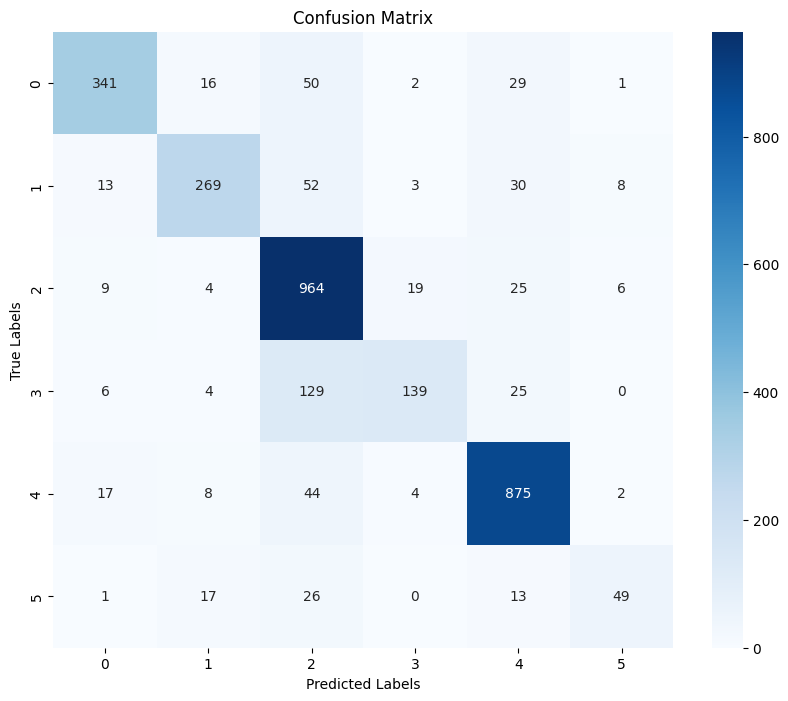

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, lg_y_pred)

# Create and display the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=meta_model.classes_, 
            yticklabels=meta_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [47]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you",
            "I Love You"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : 4
Label : 4
i feel strong and good overall
Prediction : 2
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : 0
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : 2
Label : 2
This is outrageous, how can you talk like that?
Prediction : 2
Label : 2
I feel like im all alone in this world
Prediction : 2
Label : 2
He is really sweet and caring
Prediction : 2
Label : 2
You made me very crazy
Prediction : 2
Label : 2
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : 2
Label : 2
i am feeling grouchy
Prediction : 2
Label : 2
He hates you
Prediction : 2
Label : 2
I Love You
Prediction : 3
Label : 3


## Voting CLassifier (Hard Voting)

In [48]:
from sklearn.ensemble import VotingClassifier

# Define the classifiers
classifiers = [
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("Support Vector Machine", SVC(probability=True))  # Set probability=True for SVC
]

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=classifiers, voting='hard')  # 'hard' voting: majority class label
# soft' voting (predict the class label based on the argmax of the sums of the predicted probabilities)
# voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

# Train the Voting Classifier
voting_clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_tfidf_ensemble = voting_clf.predict(X_test_tfidf)
accuracy_tfidf_ensemble = accuracy_score(y_test, y_pred_tfidf_ensemble)

print("\n===== Ensemble Voting Classifier =====")
print(f"\nAccuracy using TF-IDF: {accuracy_tfidf_ensemble}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tfidf_ensemble))

c:\Users\Yash lichade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== Ensemble Voting Classifier =====

Accuracy using TF-IDF: 0.8209375
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       439
           1       0.84      0.75      0.79       375
           2       0.74      0.96      0.84      1027
           3       0.84      0.34      0.48       303
           4       0.89      0.91      0.90       950
           5       0.80      0.42      0.55       106

    accuracy                           0.82      3200
   macro avg       0.83      0.70      0.73      3200
weighted avg       0.83      0.82      0.81      3200



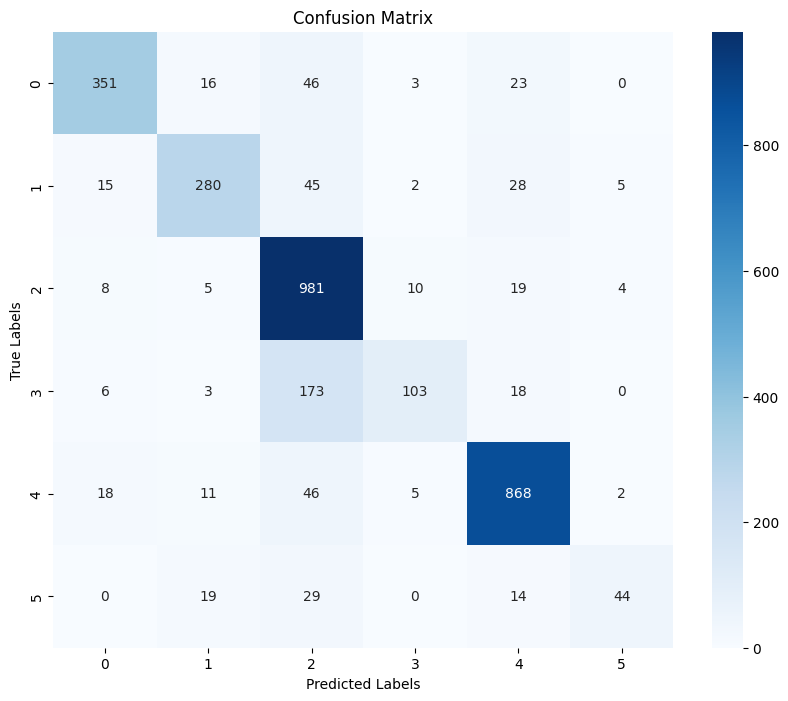

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_tfidf_ensemble)

# Create and display the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=meta_model.classes_, 
            yticklabels=meta_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Voting Classifier (Soft Voting)

In [50]:
from sklearn.ensemble import VotingClassifier

# Define the classifiers
classifiers = [
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("Support Vector Machine", SVC(probability=True))  # Set probability=True for SVC
]

# Create the Voting Classifier
# voting_clf = VotingClassifier(estimators=classifiers, voting='hard')  # 'hard' voting: majority class label
# soft' voting (predict the class label based on the argmax of the sums of the predicted probabilities)
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

# Train the Voting Classifier
voting_clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_tfidf_ensemble = voting_clf.predict(X_test_tfidf)
accuracy_tfidf_ensemble = accuracy_score(y_test, y_pred_tfidf_ensemble)

print("\n===== Ensemble Voting Classifier =====")
print(f"\nAccuracy using TF-IDF: {accuracy_tfidf_ensemble}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tfidf_ensemble))

c:\Users\Yash lichade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== Ensemble Voting Classifier =====

Accuracy using TF-IDF: 0.85125
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       439
           1       0.84      0.80      0.82       375
           2       0.82      0.93      0.87      1027
           3       0.83      0.56      0.67       303
           4       0.90      0.92      0.91       950
           5       0.74      0.61      0.67       106

    accuracy                           0.85      3200
   macro avg       0.83      0.78      0.80      3200
weighted avg       0.85      0.85      0.85      3200



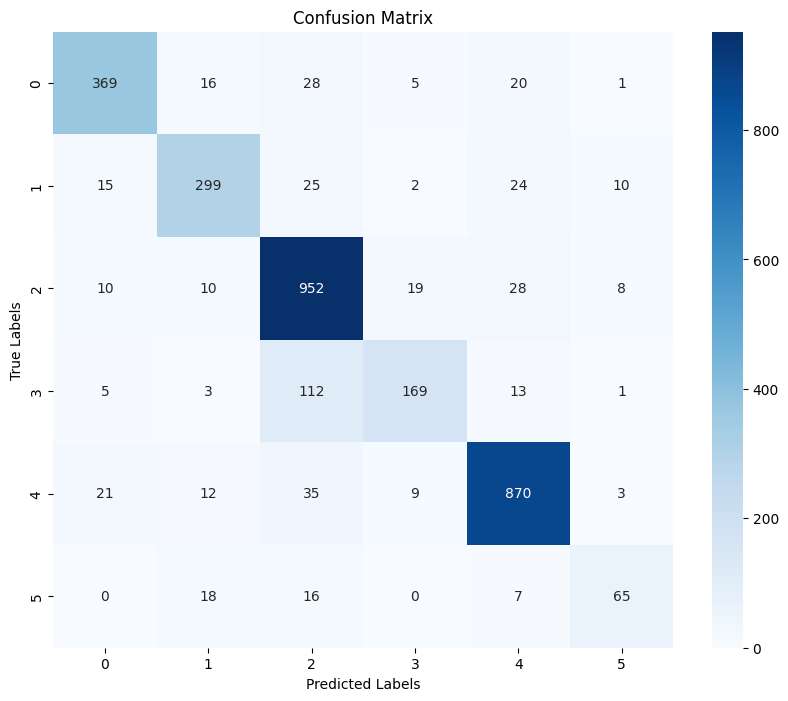

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_tfidf_ensemble)

# Create and display the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=meta_model.classes_, 
            yticklabels=meta_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Stacking Classifier 

In [28]:
# Define meta-model
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

classifiers = [
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("Support Vector Machine", SVC(probability=True))  # Set probability=True for SVC
]
meta_model = StackingClassifier(estimators=classifiers)

# Create a pipeline with TF-IDF vectorizer and StackingClassifier
pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('stacking_classifier', meta_model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_stacking = pipeline.predict(X_test)

# Evaluate the stacking classifier
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print("Stacking Classifier Accuracy:", stacking_accuracy)

c:\Users\Yash lichade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Yash lichade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Stacking Classifier Accuracy: 0.865625


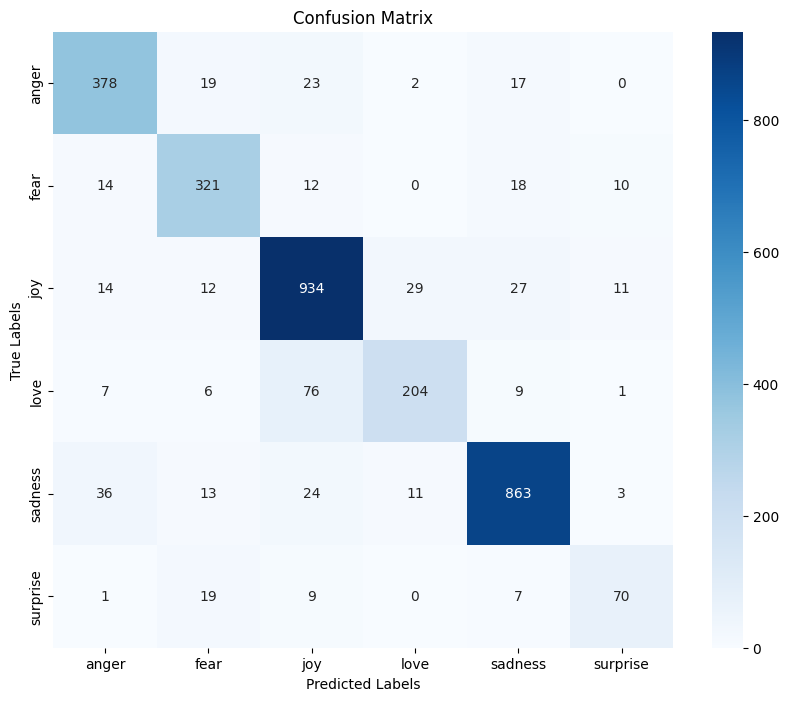

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_stacking)

# Create and display the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
         xticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
            yticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [37]:
conf_matrix

array([[378,  19,  23,   2,  17,   0],
       [ 14, 321,  12,   0,  18,  10],
       [ 14,  12, 934,  29,  27,  11],
       [  7,   6,  76, 204,   9,   1],
       [ 36,  13,  24,  11, 863,   3],
       [  1,  19,   9,   0,   7,  70]], dtype=int64)

## Saving Model

In [30]:
import pickle
pickle.dump(pipeline,open("stacking_model.pkl",'wb'))

In [31]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

[nltk_data] Downloading package stopwords to C:\Users\Yash
[nltk_data]     lichade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I feel humiliated
Prediction : sadness
Probability : 0.9982622792850261
Probabilities for each emotion: [9.57621437e-04 4.02546770e-04 2.05831950e-04 8.26958549e-05
 9.98262279e-01 8.90247034e-05]


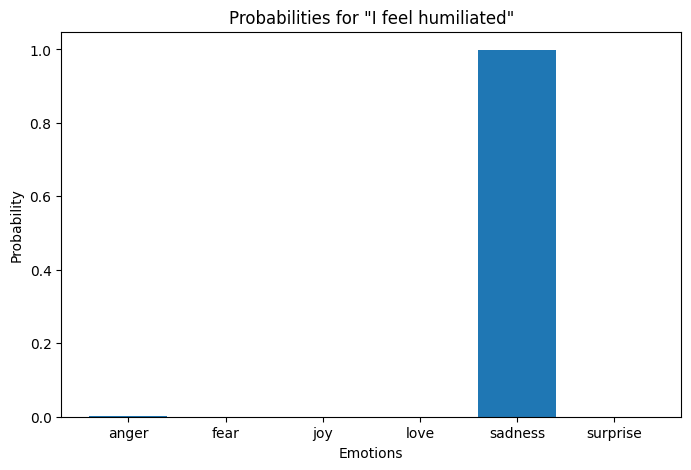

i feel strong and good overall
Prediction : joy
Probability : 0.9919785775248658
Probabilities for each emotion: [5.08291648e-04 4.54745688e-04 9.91978578e-01 6.22033158e-03
 5.08748924e-04 3.29304640e-04]


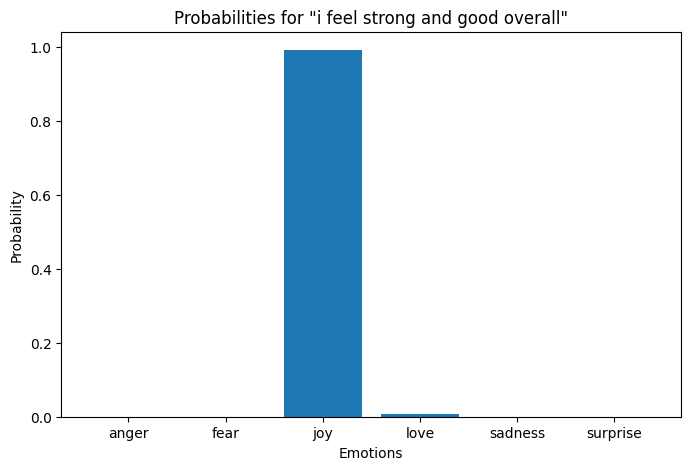

im grabbing a minute to post i feel greedy wrong
Prediction : anger
Probability : 0.9961036237985982
Probabilities for each emotion: [9.96103624e-01 1.65429582e-03 3.40729414e-04 4.81338360e-04
 1.34073162e-03 7.92809825e-05]


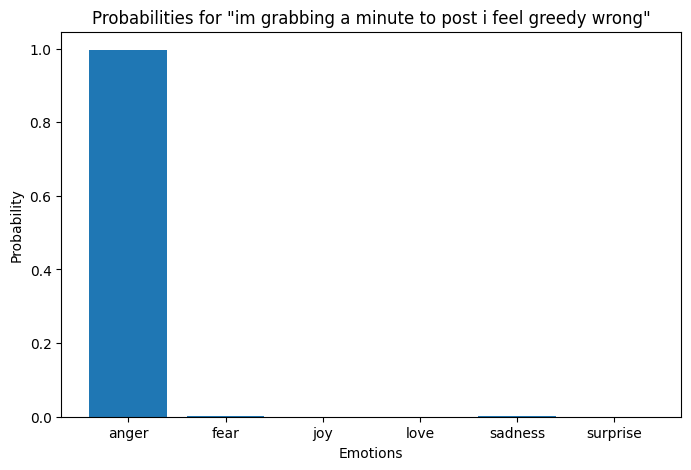

He was speechles when he found out he was accepted to this new job
Prediction : joy
Probability : 0.8533641203829668
Probabilities for each emotion: [0.02559843 0.01495765 0.85336412 0.08608664 0.01320814 0.00678501]


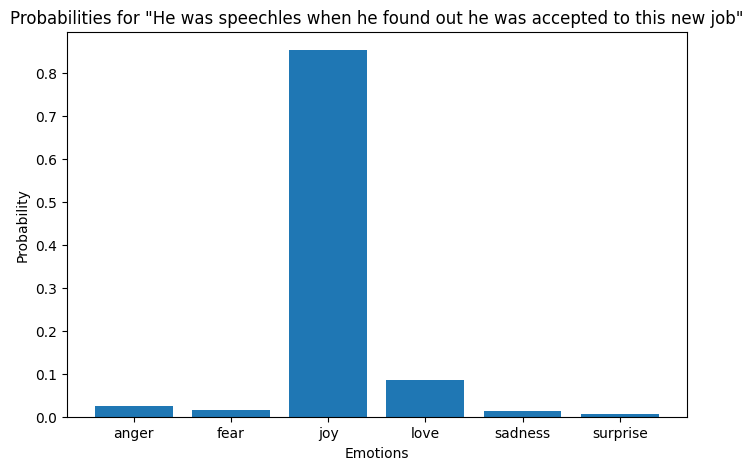

This is outrageous, how can you talk like that?
Prediction : anger
Probability : 0.9475149900830901
Probabilities for each emotion: [0.94751499 0.02577538 0.00748316 0.00457593 0.01348041 0.00117013]


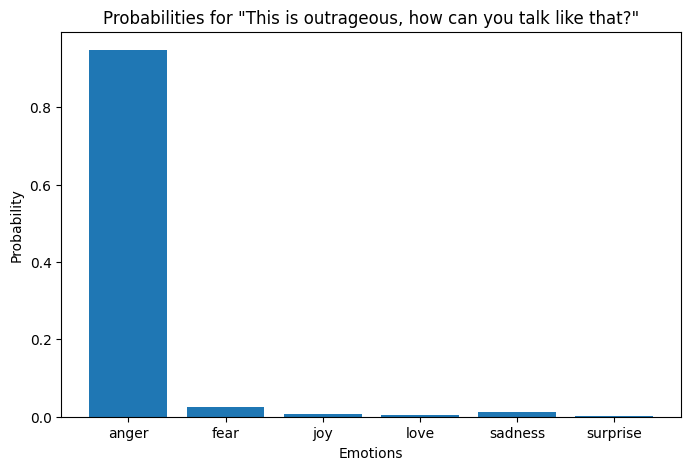

I feel like im all alone in this world
Prediction : sadness
Probability : 0.990601358008098
Probabilities for each emotion: [4.96822079e-03 2.08214653e-03 1.54472212e-03 4.74558084e-04
 9.90601358e-01 3.28994460e-04]


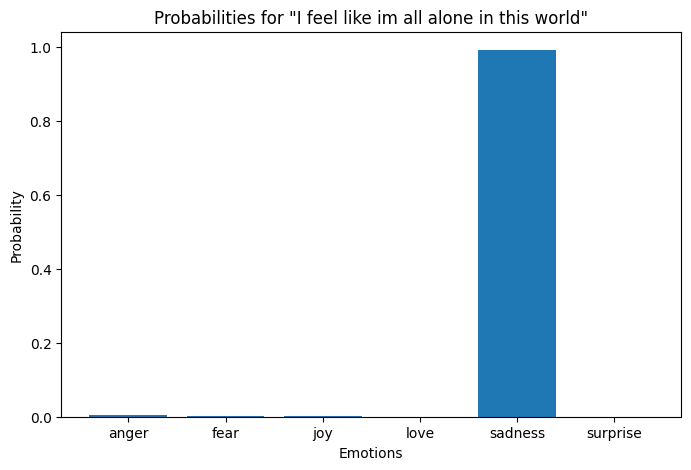

He is really sweet and caring
Prediction : love
Probability : 0.7171299286210482
Probabilities for each emotion: [0.07493343 0.06260948 0.11254465 0.71712993 0.02454461 0.00823789]


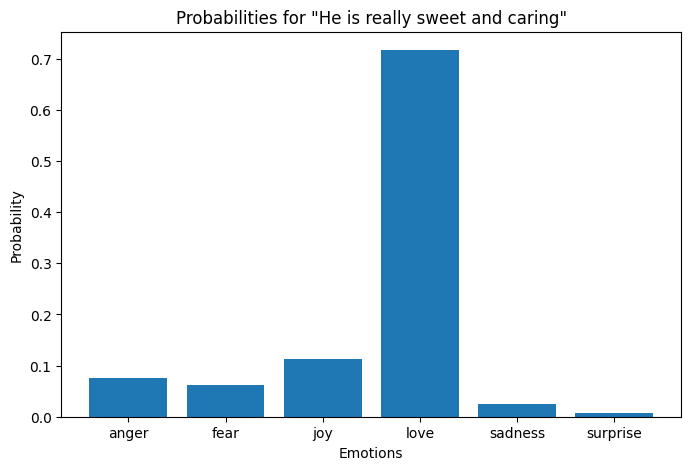

You made me very crazy
Prediction : anger
Probability : 0.5753326352714291
Probabilities for each emotion: [0.57533264 0.17652075 0.100204   0.02144107 0.11453616 0.01196539]


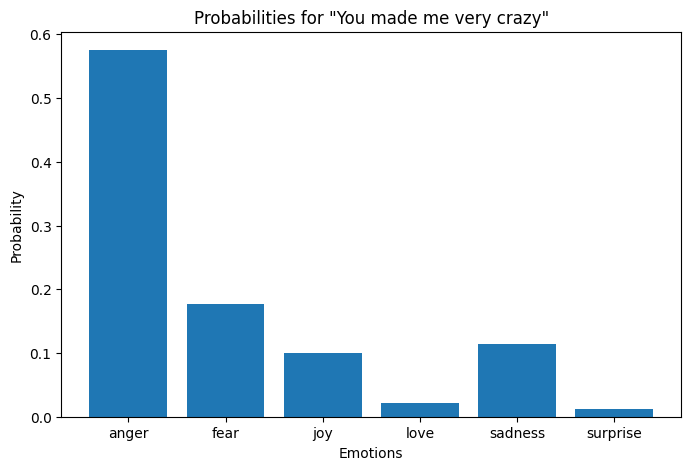

i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Probability : 0.9885737961981372
Probabilities for each emotion: [1.30832022e-03 1.29216804e-03 6.72939518e-03 9.88573796e-01
 1.44743155e-03 6.48888818e-04]


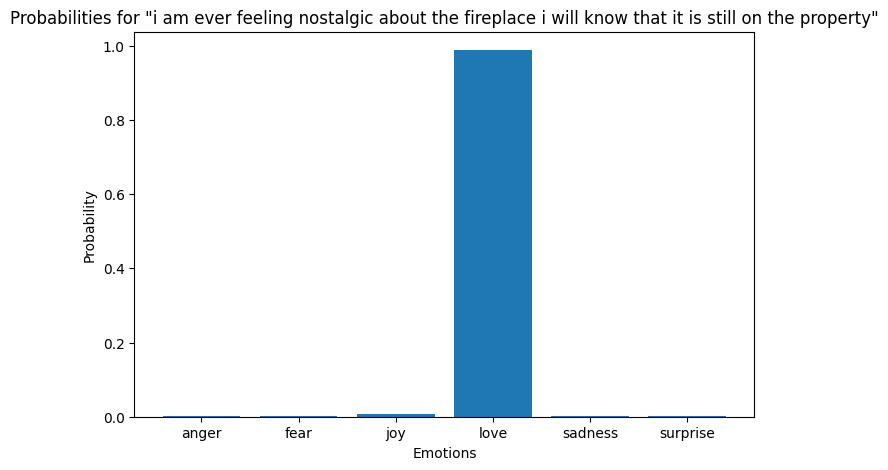

i am feeling grouchy
Prediction : anger
Probability : 0.9962730546526471
Probabilities for each emotion: [9.96273055e-01 1.61069684e-03 4.04135228e-04 4.39921235e-04
 1.19645606e-03 7.57359795e-05]


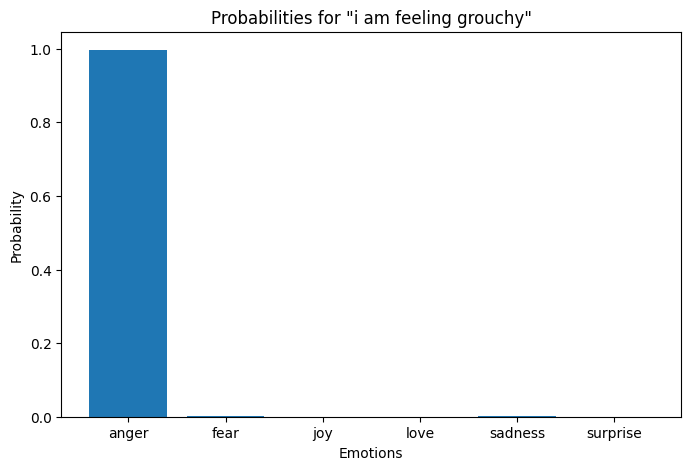

He hates you
Prediction : anger
Probability : 0.9015566466498569
Probabilities for each emotion: [0.90155665 0.02212843 0.00503248 0.00523846 0.06453985 0.00150412]


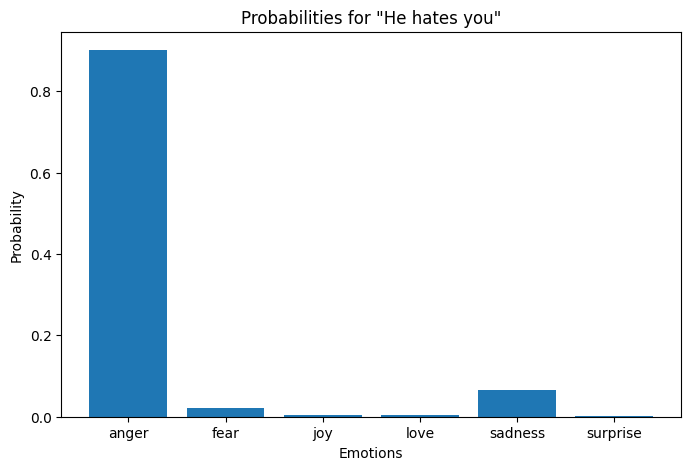

I Love You
Prediction : love
Probability : 0.8041402389200533
Probabilities for each emotion: [0.05859997 0.03038796 0.06518627 0.80414024 0.03614877 0.00553679]


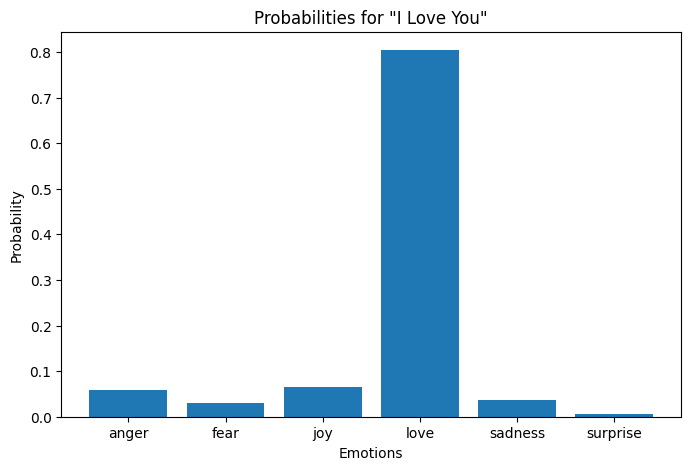

he Loves you Guys
Prediction : love
Probability : 0.7446157884159612
Probabilities for each emotion: [0.07713064 0.03488999 0.09300844 0.74461579 0.04435228 0.00600286]


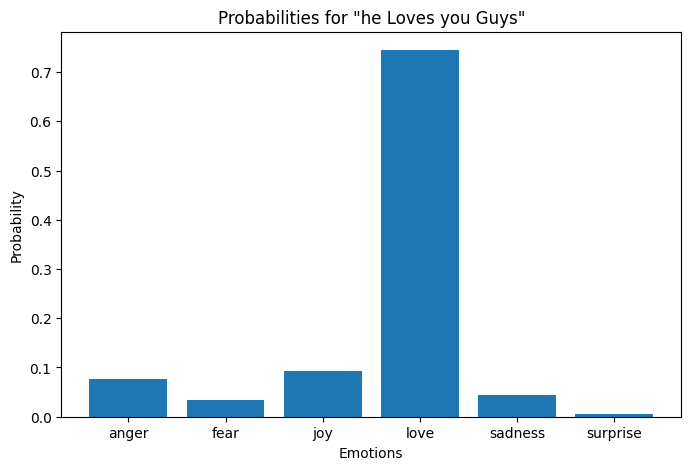

what a beautiful girl she is!
Prediction : joy
Probability : 0.42247371563656816
Probabilities for each emotion: [0.30694567 0.08755755 0.42247372 0.07878413 0.08643781 0.01780113]


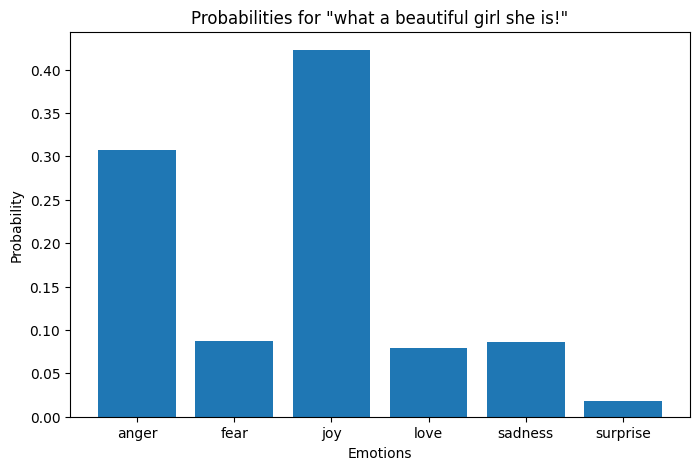

I'm terrified of spiders crawling on me
Prediction : fear
Probability : 0.9893672426574165
Probabilities for each emotion: [2.57693303e-03 9.89367243e-01 8.30188402e-04 3.26195852e-04
 1.89792149e-03 5.00151857e-03]


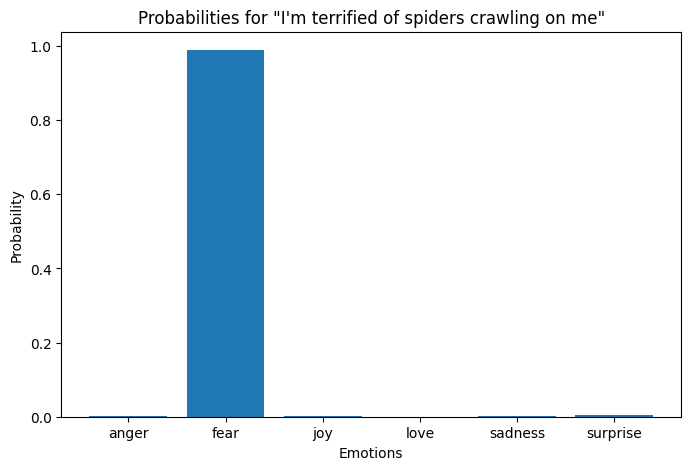

I was amazed by the gift I received
Prediction : surprise
Probability : 0.5125051865000374
Probabilities for each emotion: [0.01095878 0.04357666 0.41464077 0.00483985 0.01347876 0.51250519]


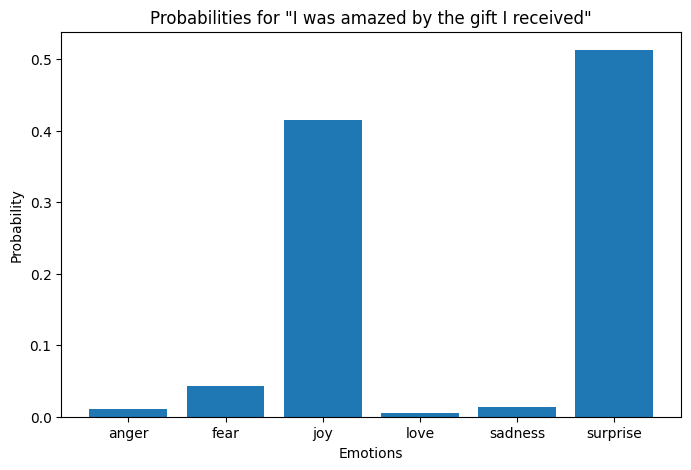

I was terrible and fearful
Prediction : fear
Probability : 0.6793566142766325
Probabilities for each emotion: [0.03233205 0.67935661 0.00600165 0.00262814 0.24955422 0.03012733]


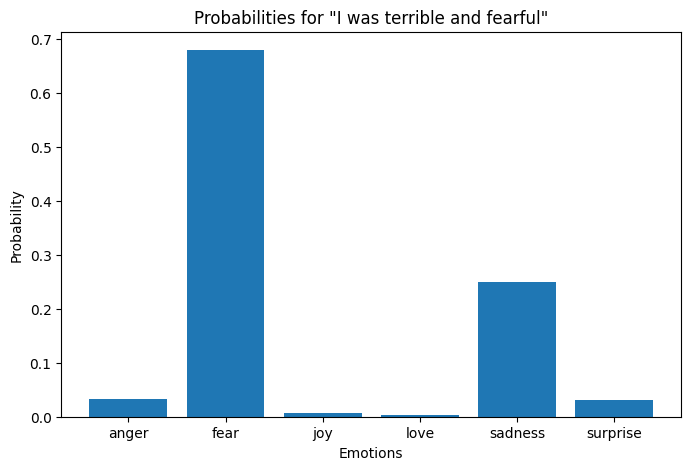

In [36]:
emotional_categories=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    
    # Make prediction
    predicted_label = pipeline.predict([cleaned_text])
    predicted_emotion = emotional_categories[predicted_label[0]]
    
    # Get the probability of the predicted label
    probabilities = pipeline.predict_proba([cleaned_text])
    label = np.max(probabilities)

    return predicted_emotion, label, probabilities[0]

# Example usage 
sentences = [
    "I feel humiliated",
    "i feel strong and good overall",
    "im grabbing a minute to post i feel greedy wrong",
    "He was speechles when he found out he was accepted to this new job",
    "This is outrageous, how can you talk like that?",
    "I feel like im all alone in this world",
    "He is really sweet and caring",
    "You made me very crazy",
    "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
    "i am feeling grouchy",
    "He hates you",
    "I Love You",
    "he Loves you Guys",
    "what a beautiful girl she is!",
    "I'm terrified of spiders crawling on me",
    "I was amazed by the gift I received",
    "I was terrible and fearful"
]

for sentence in sentences:
    print(sentence)
    pred_emotion, label, probabilities = predict_emotion(sentence)
    print("Prediction :", pred_emotion)
    print("Probability :", label)
    print("Probabilities for each emotion:", probabilities)
    
    # Plotting the probabilities
    plt.figure(figsize=(8, 5))
    plt.bar(emotional_categories, probabilities)
    plt.title(f'Probabilities for "{sentence}"')
    plt.xlabel('Emotions')
    plt.ylabel('Probability')
    plt.show()

In [23]:
# save files
import pickle
pickle.dump(lg,open("logistic_regresion.pkl",'wb'))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

# Applying Deep learning Using LSTM

# Text Cleaning, Encoding, and Padding

In [19]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

In [20]:

def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y = to_categorical(train_data["Emotion"])

# Splitting the dataset into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_temp.shape
x_val.shape
x_test.shape

(2400, 300)

# Model Building and Training


Epoch 1/5


175/175 [==============================] - 46s 250ms/step - loss: 1.4020 - accuracy: 0.4455 - val_loss: 0.9568 - val_accuracy: 0.6762
Epoch 2/5
175/175 [==============================] - 49s 278ms/step - loss: 0.5896 - accuracy: 0.8022 - val_loss: 0.4995 - val_accuracy: 0.8150
Epoch 3/5
175/175 [==============================] - 48s 274ms/step - loss: 0.2873 - accuracy: 0.9021 - val_loss: 0.4758 - val_accuracy: 0.8496
Epoch 4/5
175/175 [==============================] - 48s 275ms/step - loss: 0.1919 - accuracy: 0.9387 - val_loss: 0.4832 - val_accuracy: 0.8500
Epoch 5/5
75/75 [==============================] - 3s 46ms/step - loss: 0.4027 - accuracy: 0.8725
Test Loss: 0.4026782214641571
Test Accuracy: 0.8725000023841858


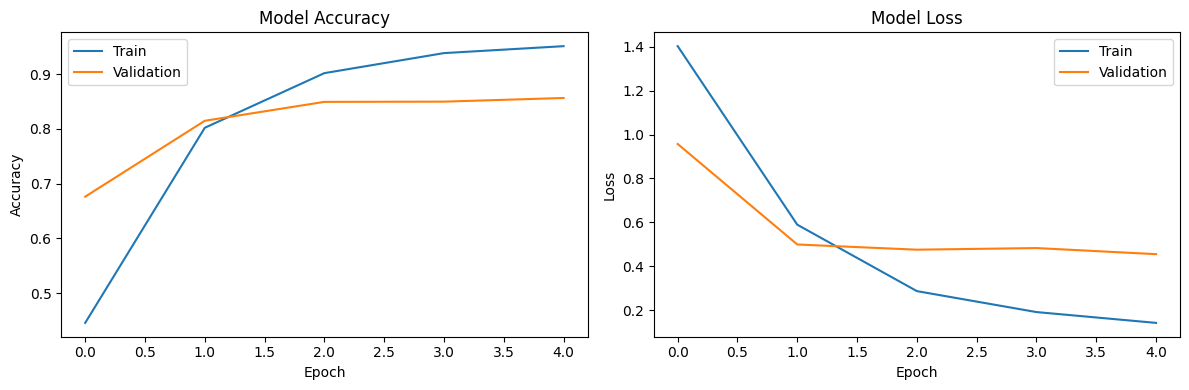

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
history = model.fit(x_train, y_train, 
                    epochs=5, 
                    batch_size=64, 
                    verbose=1, 
                    # callbacks=[callback], 
                    validation_data=(x_val, y_val))

# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Predict classes
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

75/75 [==============================] - 3s 32ms/step


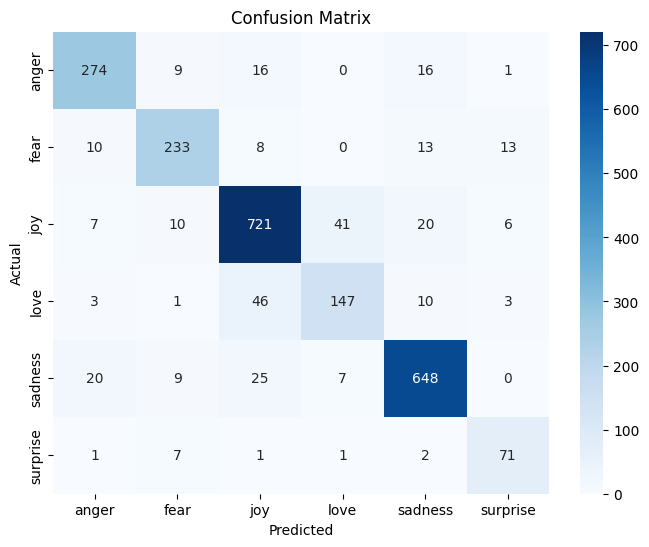

In [61]:
# Convert confusion matrix to DataFrame
conf_df = pd.DataFrame(conf_matrix, index=range(6), columns=range(6))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
            yticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [21]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Compile the model with Adam optimizer and specified learning rate, and correct metrics syntax
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    verbose=1, 
                    callbacks=[callback], 
                    validation_data=(x_val, y_val))

# Evaluate the model on test data
loss, accuracy, recall, precision = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")
print(f"Test Precision: {precision}")

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


Epoch 1/50
109/175 [=================>............] - ETA: 1:15 - loss: 1.6652 - accuracy: 0.3211

KeyboardInterrupt: 

In [46]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict 
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you",
            "Vishwesh go to hell.",
            "oh my gosh!",
            "Awesome! This is true amazing",
            "I Love You",
            "are you sad?",
            "i feel upset"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 [==============================] - 0s 50ms/step
joy : 0.9978502988815308


im grabbing a minute to post i feel greedy wrong
1/1 [==============================] - 0s 48ms/step
anger : 0.9987377524375916


He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 53ms/step
joy : 0.5617624521255493


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 56ms/step
anger : 0.8773491382598877


I feel like im all alone in this world
1/1 [==============================] - 0s 66ms/step
sadness : 0.8135491013526917


He is really sweet and caring
1/1 [==============================] - 0s 46ms/step
love : 0.7796841859817505


You made me very crazy
1/1 [==============================] - 0s 53ms/step
anger : 0.6854099035263062


i am ever feeling nostalgic about the fireplace i will know that it is still on the property
1/1 [==============================] - 0s 52ms/step
love

In [33]:
# Save the LSTM model
model.save("saved_lstm_model.h5")

c:\Users\Yash lichade\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
